In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Using device: cuda
GPU: Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached: 2.4 GB
Training dataset: 10007 images across 10 classes
Validation dataset: 2000 images across 10 classes
Model Architecture:
FlexibleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=s

  0%|          | 0/1251 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 2.2291, Val Accuracy: 21.30%


  0%|          | 0/1251 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 2.0220, Val Accuracy: 27.15%


  0%|          | 0/1251 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 1.7870, Val Accuracy: 28.85%


  0%|          | 0/1251 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 1.4431, Val Accuracy: 27.40%


  0%|          | 0/1251 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.9993, Val Accuracy: 24.85%
Training finished!


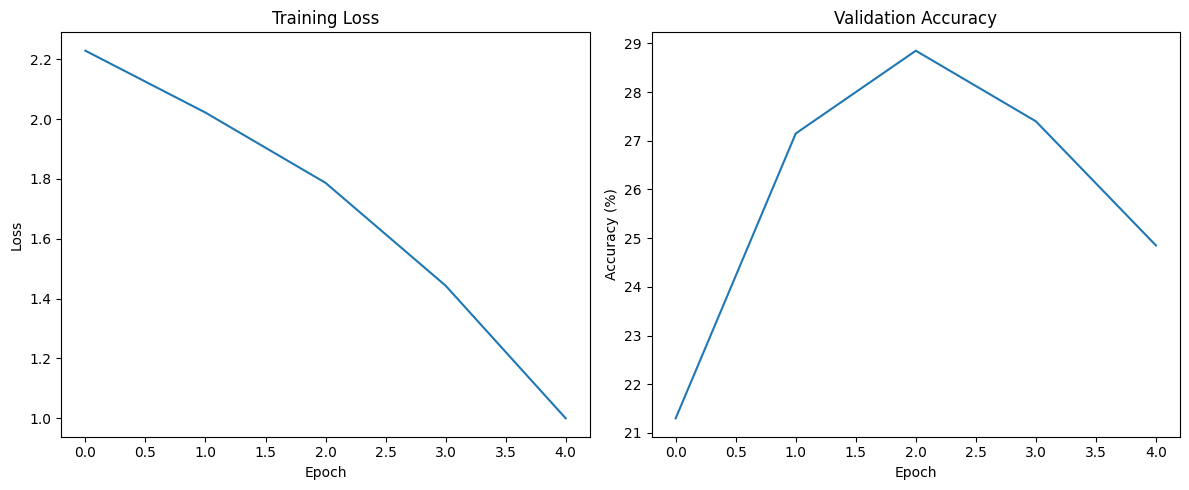

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# First, check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Usage:")
    print(f"Allocated: {round(torch.cuda.memory_allocated(0)/1024**3, 1)} GB")
    print(f"Cached: {round(torch.cuda.memory_reserved(0)/1024**3, 1)} GB")

class FlexibleCNN(nn.Module):
    def __init__(self, in_channels=3, num_filters=32, filter_size=3,
                 activation_fn=nn.ReLU, dense_neurons=128, num_classes=10, input_size=(800, 600)):
        super(FlexibleCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, num_filters, kernel_size=filter_size, padding='same'),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(num_filters, num_filters, kernel_size=filter_size, padding='same'),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(num_filters, num_filters, kernel_size=filter_size, padding='same'),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(num_filters, num_filters, kernel_size=filter_size, padding='same'),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(num_filters, num_filters, kernel_size=filter_size, padding='same'),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate output dimensions dynamically
        with torch.no_grad():
            x = torch.randn(1, in_channels, *input_size)
            x = self.features(x)
            self.flattened_size = x.numel() // x.size(0)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, dense_neurons),
            activation_fn(),
            nn.Linear(dense_neurons, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create data loaders with fixed 800x600 resizing
def create_data_loaders(train_dir, val_dir, input_size=(800, 600), batch_size=16, num_workers=2):
    """
    Create data loaders that resize all images to 800x600.
    """
    # Transform to resize all images to 800x600
    transform = transforms.Compose([
        transforms.Resize(input_size),  # Resize to 800x600
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

    print(f"Training dataset: {len(train_dataset)} images across {len(train_dataset.classes)} classes")
    print(f"Validation dataset: {len(val_dataset)} images across {len(val_dataset.classes)} classes")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,  # Smaller batch size for larger images
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, len(train_dataset.classes)

# Training function
def train_and_test_model(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    # Move model to device
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training metrics
    train_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Use tqdm for progress bar
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
        for i, (images, labels) in loop:
            # Move tensors to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validate the model
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in tqdm(val_loader, desc="Validating"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            val_accuracies.append(accuracy)

            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.2f}%')

    print('Training finished!')
    return train_losses, val_accuracies, model

# Visualize some filters from the model
def visualize_filters(model, layer_idx=0):
    # Get the first convolutional layer
    conv_layers = [module for module in model.features if isinstance(module, nn.Conv2d)]
    if layer_idx >= len(conv_layers):
        print(f"Layer index out of range. Model has {len(conv_layers)} conv layers.")
        return

    weights = conv_layers[layer_idx].weight.data.cpu().numpy()

    # Create a figure
    n_filters = weights.shape[0]
    n_rows = int(n_filters / 8) + (1 if n_filters % 8 != 0 else 0)

    plt.figure(figsize=(12, n_rows * 1.5))

    for i in range(n_filters):
        # Get the ith filter
        f = weights[i]

        # Plot each channel separately
        plt.subplot(n_rows, 8, i+1)
        # Normalize filter for better visualization
        f_min, f_max = f.min(), f.max()
        f = (f - f_min) / (f_max - f_min)

        # For RGB channels, convert to displayable image
        plt.imshow(f.transpose(1, 2, 0))
        plt.axis('off')
        plt.title(f'Filter {i+1}')

    plt.tight_layout()
    plt.show()

# Main training function
def train_inaturalist_model(train_dir, val_dir, input_size=(800, 600), num_filters=32,
                           filter_size=3, dense_neurons=128, num_epochs=5):
    # Create data loaders
    train_loader, val_loader, num_classes = create_data_loaders(
        train_dir=train_dir,
        val_dir=val_dir,
        input_size=input_size,
        batch_size=8  # Smaller batch size for large images
    )

    # Create model
    model = FlexibleCNN(
        in_channels=3,
        num_filters=num_filters,
        filter_size=filter_size,
        activation_fn=nn.ReLU,
        dense_neurons=dense_neurons,
        num_classes=num_classes,
        input_size=input_size
    )

    # Print model info
    print(f"Model Architecture:")
    print(model)
    print(f"Total trainable parameters: {count_parameters(model):,}")

    # Calculate theoretical number of computations and parameters
    h, w = input_size
    output_h, output_w = h // 32, w // 32

    # Calculations for m filters of size k×k, n dense neurons
    m = num_filters
    k = filter_size
    n = dense_neurons

    # Number of computations (MACs)
    computations = h*w*k**2*(3*m + 0.3359375*m**2) + m*(h//32)*(w//32)*n + 10*n
    print(f"Approximate number of computations (MACs): {computations:,}")

    # Number of parameters
    parameters = k**2*m*(3 + 4*m) + 5*m + m*(h//32)*(w//32)*n + 11*n + 10
    print(f"Theoretical number of parameters: {parameters:,}")

    # Train model
    train_losses, val_accuracies, model = train_and_test_model(
        model, train_loader, val_loader, num_epochs=num_epochs
    )

    # Plot results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

    # Visualize filters
    # visualize_filters(model, layer_idx=0)

    return model

# Example usage:
model = train_inaturalist_model(
    train_dir="/content/drive/MyDrive/inaturalist_12K/train",
    val_dir="/content/drive/MyDrive/inaturalist_12K/val",
    input_size=(800, 600),
    num_filters=32,
    filter_size=3,
    dense_neurons=128,
    num_epochs=5
)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import wandb
import os

# First, check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Usage:")
    print(f"Allocated: {round(torch.cuda.memory_allocated(0)/1024**3, 1)} GB")
    print(f"Cached: {round(torch.cuda.memory_reserved(0)/1024**3, 1)} GB")

# Custom transform to handle image orientation
class RotateIfNeeded:
    def __call__(self, img):
        width, height = img.size
        if height > width:
            return img.transpose(2)  # Rotate 90 degrees if portrait
        return img

# Function to create data loaders with stratified sampling
def create_data_loaders(train_dir, test_dir, input_size=(224, 224), batch_size=8,
                        data_augmentation=False, val_ratio=0.2, num_workers=2):
    """
    Create data loaders for training, validation, and testing.
    Uses stratified sampling to ensure class balance in validation set.
    """
    # Base transform
    base_transform = [
        RotateIfNeeded(),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]

    # Training transform with optional augmentation
    if data_augmentation:
        train_transform = transforms.Compose([
            base_transform[0],  # RotateIfNeeded
            base_transform[1],  # Resize
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            base_transform[2],  # ToTensor
            base_transform[3]   # Normalize
        ])
    else:
        train_transform = transforms.Compose(base_transform)

    # Test transform (no augmentation)
    test_transform = transforms.Compose(base_transform)

    # Load datasets
    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

    # Create stratified train/validation split
    targets = np.array([sample[1] for sample in train_dataset.samples])
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
    train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

    # Create samplers
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=True
    )

    val_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=val_sampler,
        num_workers=num_workers, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    print(f"Training set: {len(train_idx)} images")
    print(f"Validation set: {len(val_idx)} images")
    print(f"Test set: {len(test_dataset)} images")
    print(f"Number of classes: {len(train_dataset.classes)}")

    return train_loader, val_loader, test_loader, len(train_dataset.classes)

# Enhanced FlexibleCNN model with support for different filter organizations
class FlexibleCNN(nn.Module):
    def __init__(self, in_channels=3, num_filters=32, filter_size=3,
                 activation_fn=nn.ReLU, filter_organization='same',
                 use_batchnorm=False, dropout_rate=0.0,
                 dense_neurons=128, num_classes=10, input_size=(224, 224)):
        super(FlexibleCNN, self).__init__()

        # Determine filter counts based on organization strategy
        if filter_organization == 'same':
            filters = [num_filters] * 5
        elif filter_organization == 'double':
            filters = [num_filters * (2**i) for i in range(5)]
        elif filter_organization == 'half':
            filters = [num_filters // (2**(i)) for i in range(5)]
            filters = [max(16, f) for f in filters]  # Ensure minimum filter count

        # Build layers list
        layers = []

        # First conv block
        layers.append(nn.Conv2d(in_channels, filters[0], kernel_size=filter_size, padding='same'))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(filters[0]))
        layers.append(activation_fn())
        if dropout_rate > 0:
            layers.append(nn.Dropout2d(dropout_rate))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Remaining conv blocks
        for i in range(1, 5):
            layers.append(nn.Conv2d(filters[i-1], filters[i], kernel_size=filter_size, padding='same'))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(filters[i]))
            layers.append(activation_fn())
            if dropout_rate > 0:
                layers.append(nn.Dropout2d(dropout_rate))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.features = nn.Sequential(*layers)

        # Calculate output dimensions dynamically
        with torch.no_grad():
            x = torch.randn(1, in_channels, *input_size)
            x = self.features(x)
            self.flattened_size = x.numel() // x.size(0)

        # Classifier
        classifier_layers = [
            nn.Flatten(),
            nn.Linear(self.flattened_size, dense_neurons),
            activation_fn()
        ]

        if dropout_rate > 0:
            classifier_layers.append(nn.Dropout(dropout_rate))

        classifier_layers.append(nn.Linear(dense_neurons, num_classes))

        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Dictionary of activation functions
activation_functions = {
    'relu': nn.ReLU,
    'gelu': nn.GELU,
    'silu': nn.SiLU,
    'mish': nn.Mish
}

# Function to train model with wandb logging
def train_with_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Create data loaders
        train_loader, val_loader, test_loader, num_classes = create_data_loaders(
            train_dir=config.train_dir,
            test_dir=config.test_dir,
            input_size=(800, 600),
            batch_size=config.batch_size,
            data_augmentation=config.data_augmentation
        )

        # Create model
        model = FlexibleCNN(
            num_filters=config.num_filters,
            filter_size=config.filter_size,
            activation_fn=activation_functions[config.activation],
            filter_organization=config.filter_organization,
            use_batchnorm=config.use_batchnorm,
            dropout_rate=config.dropout_rate,
            dense_neurons=config.dense_neurons,
            num_classes=num_classes,
            input_size=(800, 600)
        )

        # Move model to device
        model = model.to(device)

        # Print model info
        print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

        # Define loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

        # Training loop
        for epoch in range(config.epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            correct = 0
            total = 0

            with tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Train]") as pbar:
                for inputs, targets in pbar:
                    inputs, targets = inputs.to(device), targets.to(device)

                    # Forward pass
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    # Backward pass
                    loss.backward()
                    optimizer.step()

                    # Track metrics
                    train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()

                    # Update progress bar
                    pbar.set_postfix({
                        'loss': train_loss / (pbar.n + 1),
                        'acc': 100. * correct / total
                    })

            train_loss = train_loss / len(train_loader)
            train_accuracy = 100. * correct / total

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                with tqdm(val_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Val]") as pbar:
                    for inputs, targets in pbar:
                        inputs, targets = inputs.to(device), targets.to(device)

                        # Forward pass
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)

                        # Track metrics
                        val_loss += loss.item()
                        _, predicted = outputs.max(1)
                        total += targets.size(0)
                        correct += predicted.eq(targets).sum().item()

                        # Update progress bar
                        pbar.set_postfix({
                            'loss': val_loss / (pbar.n + 1),
                            'acc': 100. * correct / total
                        })

            val_loss = val_loss / len(val_loader)
            val_accuracy = 100. * correct / total

            # Log metrics to wandb
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            })

            print(f"Epoch {epoch+1}/{config.epochs} - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        return model, val_accuracy

# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Bayesian optimization for efficient search
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'train_dir': {
            'value': '/content/drive/MyDrive/inaturalist_12K/train'
        },
        'test_dir': {
            'value': '/content/drive/MyDrive/inaturalist_12K/val'
        },
        'input_size': {
            'values': [256]  # Smaller image sizes to save memory
        },
        'batch_size': {
            'values': [8]  # Small batch sizes to avoid OOM
        },
        'num_filters': {
            'values': [64]  # Filter counts
        },
        'filter_size': {
            'values': [3]  # Filter sizes
        },
        'activation': {
            'values': ['relu']  # Activation functions
        },
        'filter_organization': {
            'values': ['half']  # Filter organization strategies
        },
        'data_augmentation': {
            'values': [False]  # Whether to use data augmentation
        },
        'use_batchnorm': {
            'values': [False]  # Whether to use batch normalization
        },
        'dropout_rate': {
            'values': [0.2]  # Dropout rates
        },
        'dense_neurons': {
            'values': [512]  # Number of neurons in dense layer
        },
        'learning_rate': {
            'values': [0.001]  # Learning rates
        },
        'epochs': {
            'value': 5  # Fixed number of epochs for all runs
        }
    }
}

# Initialize wandb
wandb.login()

# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="da6401_assignment2")

# Run the sweep (limit to 20 runs for efficiency)
wandb.agent(sweep_id, train_with_wandb, count=10)


Using device: cuda
GPU: Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached: 0.0 GB
Create sweep with ID: gqq629ed
Sweep URL: https://wandb.ai/cs24m048-iit-madras/da6401_assignment2/sweeps/gqq629ed


wandb: Agent Starting Run: wo4jbqvf with config:
wandb: 	activation: relu
wandb: 	batch_size: 8
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0
wandb: 	epochs: 5
wandb: 	filter_organization: same
wandb: 	filter_size: 3
wandb: 	input_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_filters: 32
wandb: 	test_dir: /content/drive/MyDrive/inaturalist_12K/val
wandb: 	train_dir: /content/drive/MyDrive/inaturalist_12K/train
wandb: 	use_batchnorm: False


Training set: 8005 images
Validation set: 2002 images
Test set: 2000 images
Number of classes: 10
Model parameters: 1,882,506


Epoch 1/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 2.2606, Train Acc: 14.33%, Val Loss: 2.2547, Val Acc: 12.44%


Epoch 2/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 2.1612, Train Acc: 20.95%, Val Loss: 2.1677, Val Acc: 23.03%


Epoch 3/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 1.9898, Train Acc: 29.14%, Val Loss: 2.1531, Val Acc: 21.83%


Epoch 4/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 1.6042, Train Acc: 43.76%, Val Loss: 2.4257, Val Acc: 21.48%


Epoch 5/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.9929, Train Acc: 66.12%, Val Loss: 3.4045, Val Acc: 19.78%


epoch,▁▃▅▆█
train_accuracy,▁▂▃▅█
train_loss,█▇▇▄▁
val_accuracy,▁█▇▇▆
val_loss,▂▁▁▃█
epoch,5
train_accuracy,66.12117
train_loss,0.99291
val_accuracy,19.78022
val_loss,3.40453


wandb: Agent Starting Run: 5uphyztf with config:
wandb: 	activation: relu
wandb: 	batch_size: 8
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0
wandb: 	epochs: 5
wandb: 	filter_organization: half
wandb: 	filter_size: 3
wandb: 	input_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_filters: 32
wandb: 	test_dir: /content/drive/MyDrive/inaturalist_12K/val
wandb: 	train_dir: /content/drive/MyDrive/inaturalist_12K/train
wandb: 	use_batchnorm: False


Training set: 8005 images
Validation set: 2002 images
Test set: 2000 images
Number of classes: 10
Model parameters: 935,498


Epoch 1/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 2.2969, Train Acc: 11.32%, Val Loss: 2.3126, Val Acc: 13.39%


Epoch 2/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 2.2166, Train Acc: 17.34%, Val Loss: 2.1740, Val Acc: 20.43%


Epoch 3/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 2.1093, Train Acc: 23.21%, Val Loss: 2.0980, Val Acc: 24.68%


Epoch 4/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 1.9384, Train Acc: 30.48%, Val Loss: 2.1840, Val Acc: 24.18%


Epoch 5/5 [Train]:   0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 1.5705, Train Acc: 44.23%, Val Loss: 2.3929, Val Acc: 22.53%


epoch,▁▃▅▆█
train_accuracy,▁▂▄▅█
train_loss,█▇▆▅▁
val_accuracy,▁▅██▇
val_loss,▆▃▁▃█
epoch,5
train_accuracy,44.23485
train_loss,1.57047
val_accuracy,22.52747
val_loss,2.39293


In [ ]:
# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Bayesian optimization for efficient search
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'train_dir': {
            'value': '/content/drive/MyDrive/inaturalist_12K/train'
        },
        'test_dir': {
            'value': '/content/drive/MyDrive/inaturalist_12K/val'
        },
        'input_size': {
            'values': [256]  # Smaller image sizes to save memory
        },
        'batch_size': {
            'values': [8,16,32]  # Small batch sizes to avoid OOM
        },
        'num_filters': {
            'values': [64]  # Filter counts
        },
        'filter_size': {
            'values': [3]  # Filter sizes
        },
        'activation': {
            'values': ['relu']  # Activation functions
        },
        'filter_organization': {
            'values': ['half']  # Filter organization strategies
        },
        'data_augmentation': {
            'values': [False]  # Whether to use data augmentation
        },
        'use_batchnorm': {
            'values': [False]  # Whether to use batch normalization
        },
        'dropout_rate': {
            'values': [0.2]  # Dropout rates
        },
        'dense_neurons': {
            'values': [512]  # Number of neurons in dense layer
        },
        'learning_rate': {
            'values': [0.001]  # Learning rates
        },
        'epochs': {
            'value': 10  # Fixed number of epochs for all runs
        }
    }
}

# Initialize wandb
wandb.login()

# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="da6401_assignment2")

# Run the sweep (limit to 20 runs for efficiency)
wandb.agent(sweep_id, train_with_wandb, count=10)